# Project Proposal - Group 108

### Introduction

For our project we will analyze player stats for the Top 500 tennis players. Tennis is a racket sport played on courts everywhere. Some major tournaments include Wimbledon, the US Open, the Australian Open, and the French Open. Our dataset contains a variety of information including the player’s age, handedness, name, height, seasons, titles won, best season, etc.

Through analyzing the dataset we aim to answer the following question:

> **Can you predict a tennis player's career earnings based on their profile?**


### Preliminary Data Analysis

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [2]:
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
tennis <- read_csv(url)
head(tennis, n=8)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,28 (18-11-1991),United States,Right-handed,Wikipedia,307 (131),213 (31-10-2016),Sekou Bangoura,Two-handed,"$278,709",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,21 (12-05-1998),"Taiwan, Province of China",Right-handed,Wikipedia,232 (205),229 (04-11-2019),Tung Lin Wu,Two-handed,"$59,123",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


For our model, the columns of interest are: 

1. Age
2. Best Rank 
3. Current Rank
4. Seasons Played
5. Prize Money

The first four are predictors and prize money is the target variable. These five variables were selected because they have a substantial amount of observations compared to other variables which contained many empty cells.

To tidy the data, we isolated the predictors of interest and removed empty observations.

In [3]:
colnames(tennis) <- make.names(colnames(tennis))
tennis <- tennis |>
    select(Age,  Current.Rank, Best.Rank, Prize.Money, Seasons)|>
    separate(col = Age,
             into= c("age", "Date"),
             sep = " ",
            convert = TRUE) |>
    separate(col = Current.Rank,
             into= c("current_rank", "date_of_rank"),
             sep = " ",
            convert = TRUE) |>
    separate(col = Best.Rank,
             into= c("best_rank", "date_or_best_rank"),
             sep = " ",
            convert = TRUE) |>
    select(age, current_rank, best_rank, Prize.Money, Seasons)
head(tennis, n= 8)

age,current_rank,best_rank,Prize.Money,Seasons
<int>,<int>,<int>,<chr>,<dbl>
26,378,363,NA,NA
18,326,316,"$59,040",NA
32,178,44,"US$3,261,567",14
21,236,130,"$374,093",2
27,183,17,"US$6,091,971",11
22,31,31,"$1,517,157",5
28,307,213,"$278,709",1
21,232,229,"$59,123",1


In [4]:
tennis$Prize.Money <- gsub("US", "", tennis$Prize.Money)
tennis$Prize.Money <- gsub("all-time leader in earnings", "", tennis$Prize.Money)
tennis$Prize.Money <- gsub("11th", "", tennis$Prize.Money)
tennis$Prize.Money <- gsub("24th", "", tennis$Prize.Money)
tennis$Prize.Money <- gsub("10th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("14th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("27th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("15th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("30th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("All-time leader in earnings", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("4th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("28th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("2nd", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("6th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("33rd", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("26th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("24th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("48th", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("41st", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("\\$","", tennis$Prize.Money)
tennis$Prize.Money <- sub(" ", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("   ", "", tennis$Prize.Money)
tennis$Prize.Money <- sub("  ", "", tennis$Prize.Money)
tennis$Prize.Money <- sub(" all-time in earnings", "", tennis$Prize.Money)
tennis$Prize.Money <- gsub(",", "", tennis$Prize.Money)

tennis <- tennis |>
        rename(seasons_played = Seasons)

tennis <- tennis |>
    mutate(prize_money = as.numeric(Prize.Money)) |>
    select(age, current_rank, best_rank, seasons_played, prize_money) |>
    na.omit()
head(tennis, n = 8)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,current_rank,best_rank,seasons_played,prize_money
<int>,<int>,<int>,<dbl>,<dbl>
32,178,44,14,3261567
21,236,130,2,374093
27,183,17,11,6091971
22,31,31,5,1517157
28,307,213,1,278709
21,232,229,1,59123
25,417,253,5,122734
20,104,104,3,74927


Splitting the data into training (75 %) the testing (25 %) datasets

In [5]:
tennis_split <- initial_split(tennis, prop = .75, strata = prize_money)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

Summary statistics:

In [6]:
tennis_summary_mean <- tennis_train |>
    map_df(mean)
tennis_summary_max <- tennis_train |>
    map_df(max)
tennis_summary_min <- tennis_train |>
    map_df(min)
tennis_summary_med <- tennis_train |>
    map_df(median)

print("Training Data Mean")
tennis_summary_mean

print("Training Data Median")
tennis_summary_med

print("Training Data Maximum Values")
tennis_summary_max

print("Training Data Minimum Values")
tennis_summary_min

[1] "Training Data Mean"


age,current_rank,best_rank,seasons_played,prize_money
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26.62637,201.1575,123.967,6.589744,4557800


[1] "Training Data Median"


age,current_rank,best_rank,seasons_played,prize_money
<int>,<int>,<int>,<dbl>,<dbl>
26,186,96,5,666174


[1] "Training Data Maximum Values"


age,current_rank,best_rank,seasons_played,prize_money
<int>,<int>,<int>,<dbl>,<dbl>
40,494,488,22,181254572


[1] "Training Data Minimum Values"


age,current_rank,best_rank,seasons_played,prize_money
<int>,<int>,<int>,<dbl>,<dbl>
18,2,1,1,4166


The large spread of the training data (max - min) means our model can be applied to a wide range of testing data. Furthermore, the mean and the median are similar for age, current rank and seasons played, but not for best rank and prize money.

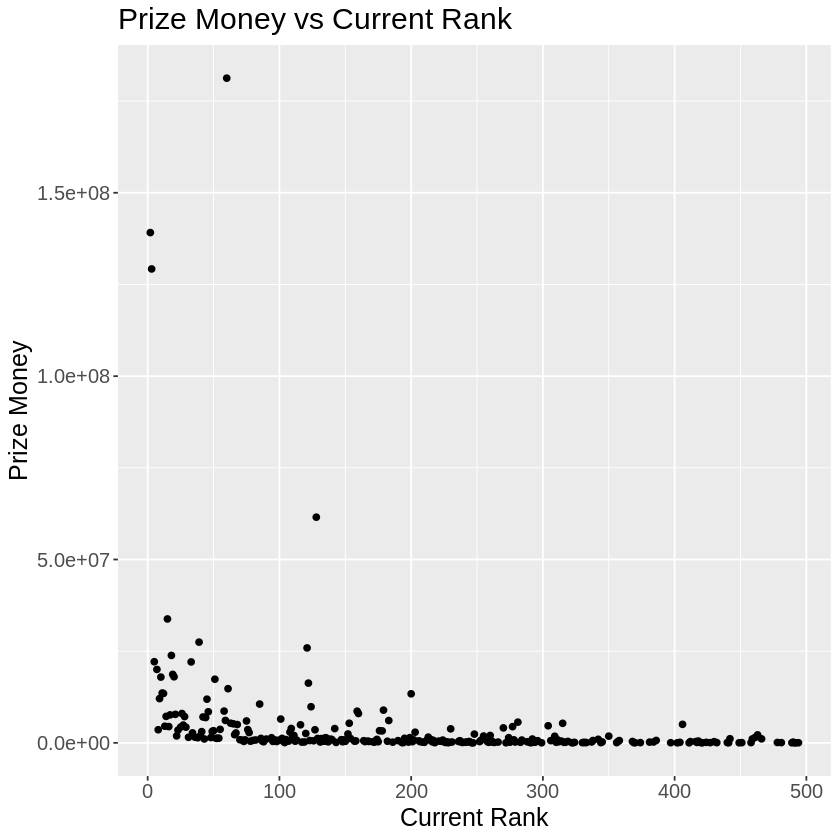

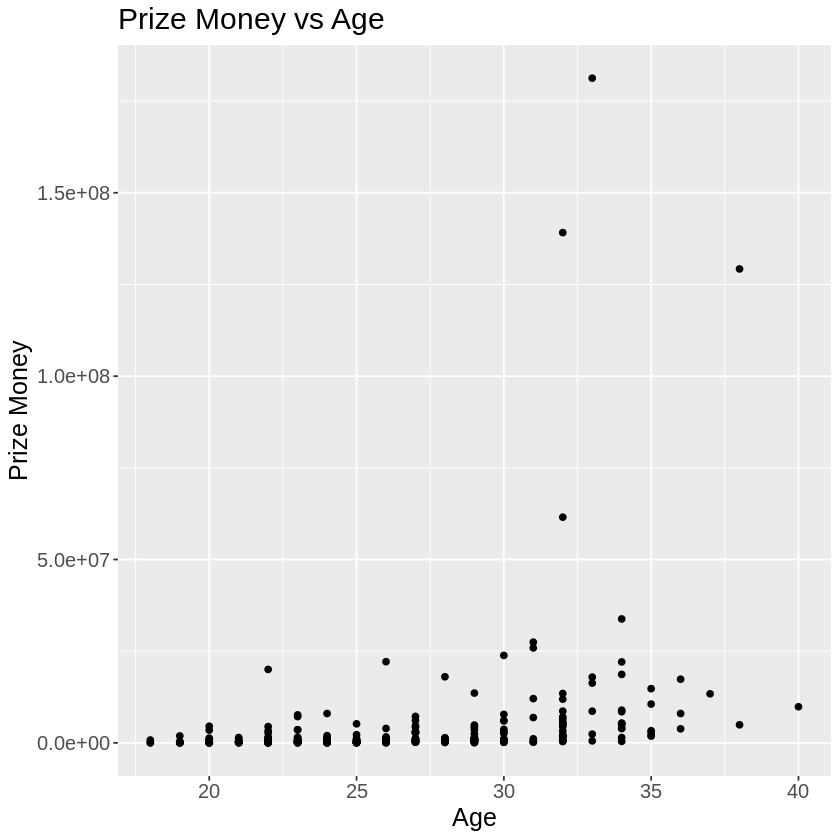

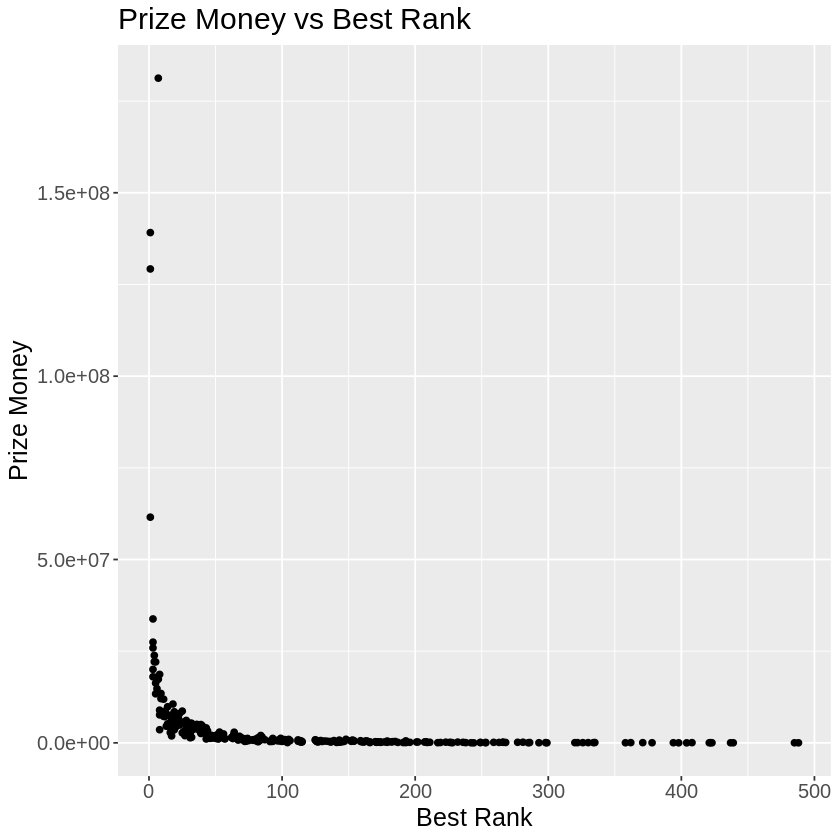

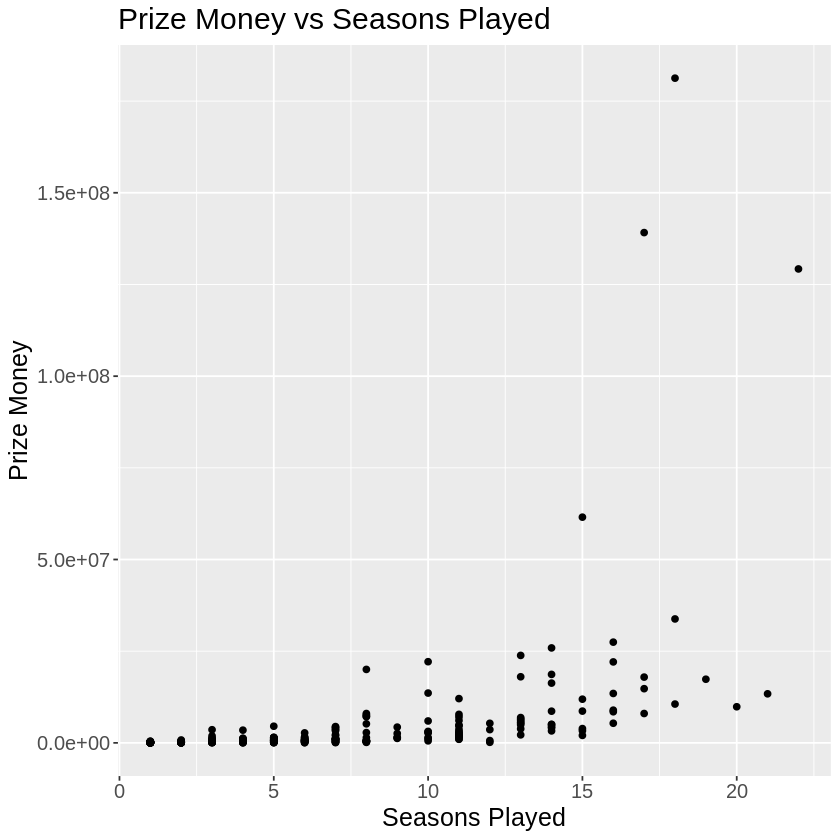

In [7]:
ggplot(tennis_train, aes(x=current_rank,y=prize_money))+
    geom_point() +
    labs(title = "Prize Money vs Current Rank", x="Current Rank", y = "Prize Money") +
    theme(text = element_text(size = 15))
ggplot(tennis_train, aes(x=age,y=prize_money))+
    geom_point()+
    labs(title = "Prize Money vs Age", x="Age", y = "Prize Money") +
    theme(text = element_text(size = 15))
ggplot(tennis_train, aes(x=best_rank,y=prize_money))+
    geom_point()+
    labs(title = "Prize Money vs Best Rank", x="Best Rank", y = "Prize Money") +
    theme(text = element_text(size = 15))
ggplot(tennis_train, aes(x=seasons_played,y=prize_money))+
    geom_point()+
    labs(title = "Prize Money vs Seasons Played", x="Seasons Played", y = "Prize Money") +
    theme(text = element_text(size = 15))

Age and Seasons Played both have a positive, exponential relationship with Prize Money, while Best Rank and Current Rank have a negative relationship that resembles an exponential decay. There also seems to be four outliers with large amounts of Prize Money.

### Methods

Since all the variables are quantitative, we will utilize the K-nearest neighbors regression to analyze the data. Using the training data, all predictors will be standardized and the model parameter will be determined through cross validation. The number of neighbors used in the final model will have the smallest estimated error from the five fold cross validation. The retrained model with the optimal number of neighbors will be evaluated by calculating its standard error on the testing set. Furthermore, each predictor will undergo this process individually to determine whether adding more predictors creates a more accurate model.

A scatter plot with Prize money on the y-axis and a predictor on the x-axis will be used to visualize the results. Each predictor will be plotted separately with a coloured line that represents the predicted prize money from the model with that predictor only.

### Expected Outcomes

We expect older players with more experience (i.e more seasons) to have a better rank which leads to higher career earnings. This is because experience is integral for winning hence more experienced players will have a higher chance of winning tournaments and earning more prize money. Moreover, playing for longer allows for more time to accumulate earnings.

We will create a model that accurately predicts a future tennis player’s prize money based on their projected seasons played, highest rank and retirement age. This would be a good path finder for such future players who in turn can understand their future goals and hence be fueled with motivation.

* What other variables affect career earnings in tennis?
* How does tennis’s prize money model compare with other sports' prize money model?
